In [3]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakubmiksa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """ 

    def __init__(self, clean_pattern = r"[^A-Za-z0-9\s\r?\n|\r]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[^A-Za-z\s\r?\n|\r]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()

In [5]:
df = pd.read_excel('sentences_with_sentiment.xlsx')

In [6]:
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


In [7]:
def label_2_int(x):
    if x['Positive'] == 1:
        return 2
    if x['Neutral'] == 1:
        return 1
    if x['Negative'] == 1:
        return 0

def label_2_name(x):
    if x['Positive'] == 1:
        return 'Positive'
    if x['Neutral'] == 1:
        return 'Neutral'
    if x['Negative'] == 1:
        return 'Negative'

In [8]:
df['label'] = df.apply(label_2_int, axis=1)
df['label_name'] = df.apply(label_2_name, axis=1)

In [9]:
df['label'].value_counts()

2    160
1     70
0     36
Name: label, dtype: int64

In [10]:
df_duplicates = df.groupby('Sentence').agg({'ID': 'count', 'Positive': 'sum', 'Negative': 'sum', 'Neutral': 'sum'}).reset_index()
df_duplicates = df_duplicates.loc[df_duplicates.ID > 1, :]
(df_duplicates.ID-1).sum()
df = df.drop_duplicates(subset=['Sentence'])

In [11]:
fig = px.histogram(df,
             x = 'label',
             title = 'Histogram of Sentiments',
             template = 'ggplot2',
             color = 'label',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [12]:
with pd.option_context('display.max_colwidth', None):
    display(df.loc[:3]['Sentence'])

0                                         The results in 2nd line treatment show an ORR of 33% with some patients having durable responses resulting in an apparent PFS plateau
1    The long duration of response and high durable response rate observed after 6-month minimum follow-up is further substantiated by the 12-months minimum follow-up analysis
2                                                                                                                     The median OS time in the updated results exceeded 1 year
3             Therefore, the clinical benefit in 2nd line treatment is considered clinically meaningful and the magnitude of the effect is significant compared to chemotherapy
Name: Sentence, dtype: object

In [13]:
df["Sentence"] = df["Sentence"].apply(lambda x: remove_punct(clean(x.lower())[0][0]))

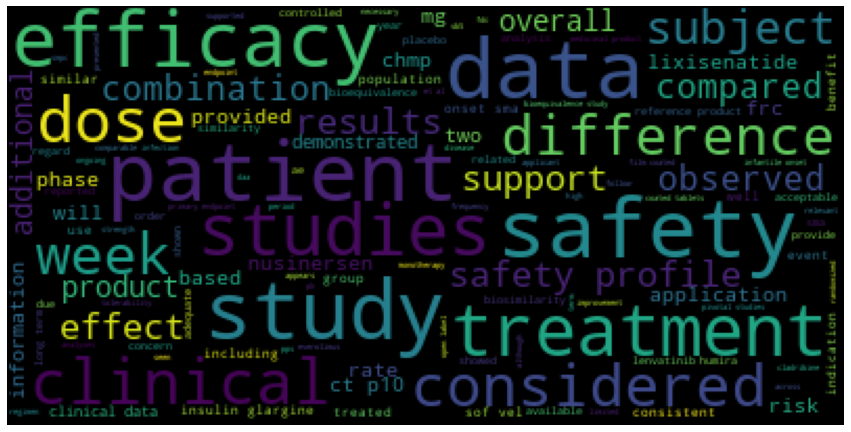

In [14]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df["Sentence"].values)

In [15]:
# tokenize data
df["tokenized_review"] = df.Sentence.apply(lambda x: tokenize(x))
# calculate token count for any sent
df["sent_token_length"] = df["tokenized_review"].apply(lambda x: len(x.split()))

In [16]:
fig = px.histogram(df, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [17]:
(df.sent_token_length).mean()

26.10169491525424

In [18]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [19]:
df["sent_bert_token_length"] = df["Sentence"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

In [20]:
df

,ID,Sentence,Positive,Negative,Neutral,label,label_name,tokenized_review,sent_token_length,sent_bert_token_length
0,1,the results in 2nd line treatment show an orr ...,1,0,0,2,Positive,the results in 2 nd line treatment show an orr...,24,24
1,2,the long duration of response and high durable...,1,0,0,2,Positive,the long duration of response and high durable...,28,31
2,3,the median os time in the updated results exce...,0,0,1,1,Neutral,the median os time in the updated results exce...,11,11
3,4,therefore the clinical benefit in 2nd line tr...,1,0,0,2,Positive,therefore the clinical benefit in 2 nd line tr...,24,24
4,5,the data provided in 1st line although prelim...,1,0,0,2,Positive,the data provided in 1 st line although prelim...,44,45
...,...,...,...,...,...,...,...,...,...,...
261,262,compared to sof vel and placebo there were si...,1,0,0,2,Positive,compared to sof vel and placebo there were sim...,28,35
262,263,other potentially related ae s including decre...,0,0,1,1,Neutral,other potentially related ae s including decre...,13,14
263,264,no treatment related sae was reported and only...,1,0,0,2,Positive,no treatment related sae was reported and only...,30,34
264,265,there was no general indication of vox associa...,0,1,0,0,Negative,there was no general indication of vox associa...,41,50


In [21]:
# valvulate char count for each review
df['char_count'] = df['Sentence'].apply(lambda x: len(str(x)))
def plot_dist3(df, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)


/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



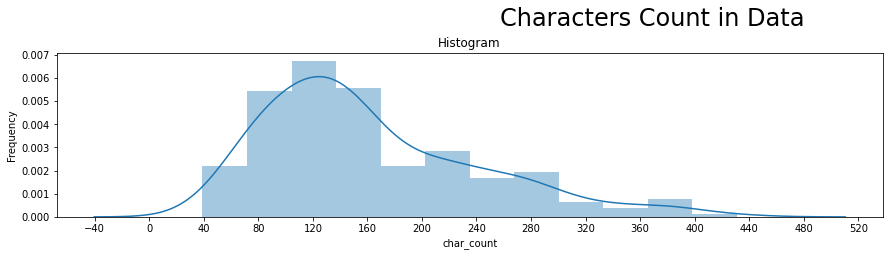

In [22]:
plot_dist3(df, 'char_count',
           'Characters Count in Data')

In [23]:
def plot_word_number_histogram(textno, textye, textz):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textz.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')

    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('negative')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('netrual')
    axes[2].set_xlabel('Word Count')
    axes[2].set_title('positive')
    
    fig.suptitle('Words Per Review', fontsize=24, va='baseline')
    
    fig.tight_layout()


In [26]:
# df[df['label'] == 0]['Sentence']

/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (

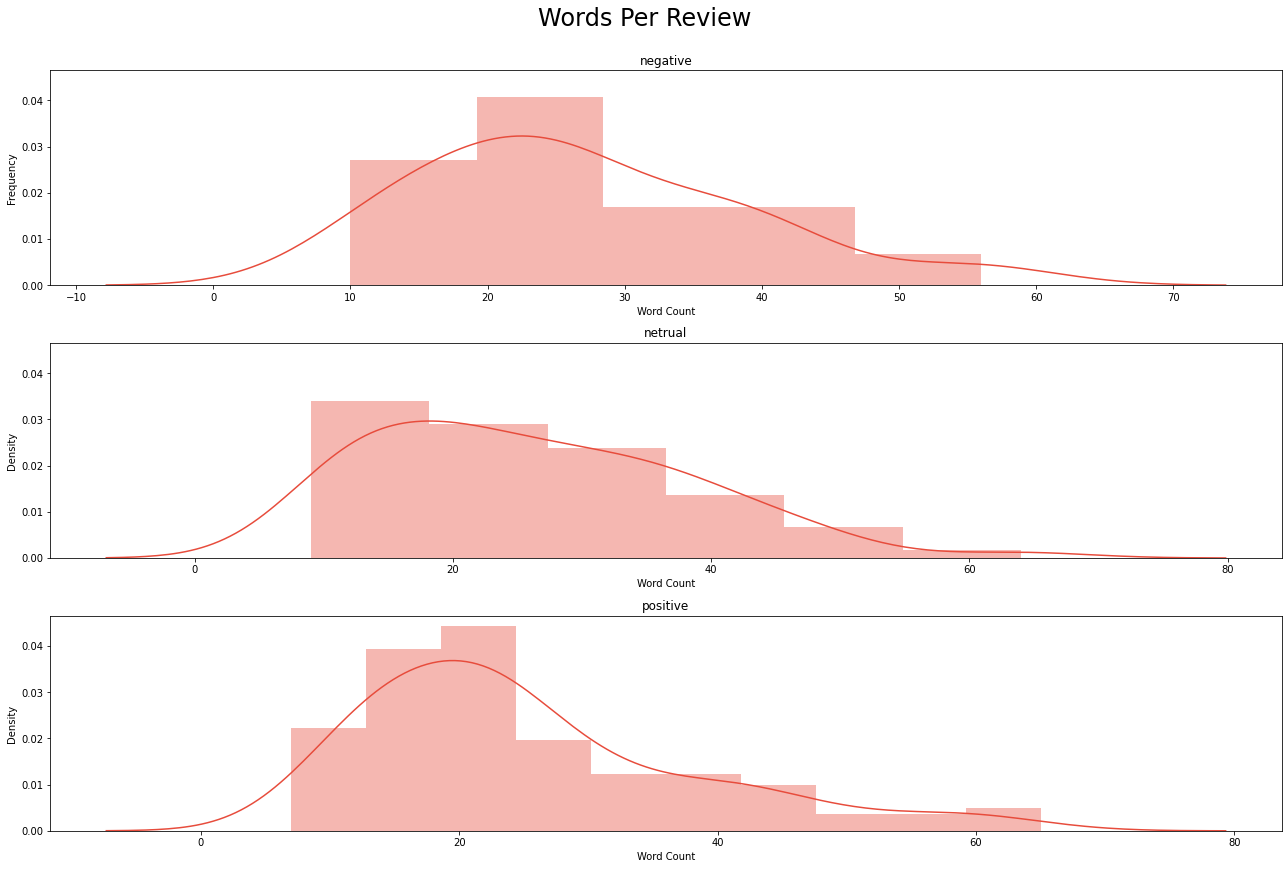

In [28]:
plot_word_number_histogram(df[df['label_name'] == 'Negative']['Sentence'],
                           df[df['label_name'] == 'Neutral']['Sentence'],
                           df[df['label_name'] == 'Positive']['Sentence'],
                          );

In [29]:
texts = df['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

In [30]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    
fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [31]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [32]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)
    

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))      
fig.show()

In [33]:
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = df[df["label"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
    
fig.show()


In [34]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [35]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [36]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5 
    batch_size = 64
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    #test_size=0.15
    random_state=42
    add_special_tokens=True 
    return_attention_mask=True 
    pad_to_max_length=True 
    do_lower_case=False
    return_tensors='pt'

config = Config()

In [38]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs, 
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    #"test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [39]:
# set random seed and device
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [40]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, 
                                    test_size=0.10, 
                                    random_state=config.random_state, 
                            stratify=df.label.values)

In [41]:
print(len(train_df['label'].unique()))
print(train_df.shape)


3
(212, 11)


In [42]:
# count of unique label  control 
print(len(val_df['label'].unique()))
print(val_df.shape)

3
(24, 11)


In [43]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, 
                                          do_lower_case=config.do_lower_case)

In [44]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.Sentence.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.Sentence.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [45]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [46]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [47]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [48]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=config.batch_size)

In [49]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr, 
                  eps=config.eps)
                  

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [50]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [51]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(config.device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [52]:
model.to(config.device)
    
for epoch in tqdm(range(1, config.epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    # allows you to see the progress of the training 
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(config.device) for b in batch)
        
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    
    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs 
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1339536607265472
Validation loss: 0.9719271659851074
F1 Score (Weighted): 0.548132183908046


Epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9371193498373032
Validation loss: 0.9316241145133972
F1 Score (Weighted): 0.4298245614035088


Epoch 3:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9141324609518051
Validation loss: 0.9032729268074036
F1 Score (Weighted): 0.4298245614035088


Epoch 4:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.8586496710777283
Validation loss: 0.8743288516998291
F1 Score (Weighted): 0.4099099099099098


Epoch 5:   0%|          | 0/4 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.8752129375934601
Validation loss: 0.8703985810279846
F1 Score (Weighted): 0.4099099099099098


In [58]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(np.argmax(predictions, axis=1).flatten(),true_vals, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.93      0.57      0.70        23

    accuracy                           0.54        24
   macro avg       0.31      0.19      0.23        24
weighted avg       0.89      0.54      0.67        24



/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/jakubmiksa/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [72]:
# np.exp(predictions)/sum(np.exp(predictions))